First, let's load all the necessary libraries:

In [5]:
library(openxlsx)
library(ggplot2)
library(ggrepel)
library(foreach)

Warning message:
"package 'foreach' was built under R version 3.5.2"

Loading the functions:

In [2]:
source('functions.R')
source("visualizations.R")

Next we'll read the peak information and intensities from the provided Excel file. The file contains 538 features from a LC-MS experiment with HILIC column and negative ionization.

In [3]:
X <- read.xlsx("HILIC_NEG_TEST.xlsx", sheet = 1)
P <- read.xlsx("HILIC_NEG_TEST.xlsx", sheet = 2)

# compute the median peak area for each feature, used in visualizations
P$MPA <- sapply(X[P$Name], median, na.rm = TRUE)

This function finds connections between features according to set conditions: correlation threshhold and retention time window. If two features have a Pearson correlation coefficient above the set threshold and their retention times differ less than the set window, they are deemed connected.

The function returns a data frame with one row per connection, with the following columns:
- x & y: the names of the features
- cor: the pearson correlation coefficient
- mz_diff: the mass difference between the features
- rt_diff: the retention time difference between the features

In [6]:
conn <- find_connections(data = X, features = P, corr_thresh = 0.85, rt_window = 1/60, name_col = "Name", mz_col = "mz", rt_col = "rt")

Warning message:
"executing %dopar% sequentially: no parallel backend registered"

[1] 100
[1] 200
[1] 300
[1] 400
[1] 500


The next part is where the actual ~~magic~~ science happens. The algorithm first constructs a network of the connected features, then starts stripping down the connected components of the network until we are left with densely connected clusters. The threshold for the relative degree can be set by the user. For example, using a degree threshold of 0.8 means that all the features in a cluster need to be connected with 80% of the other features of the cluster.

In [7]:
clusters <- find_clusters(conn)

31 components found

15 components found

11 components found

3 components found



The resulting list has one element per cluster, each containing a character vector of feature names and an igraph object of the cluster graph. The graph object is useful for plotting

Now that we know which features are clustered together we can create modified versions of the original intensity and feature information data frames. 

In [ ]:
pulled <- pull_features(clusters, data= X, features = P, name_col = "Name")
cdata <- pulled$cdata
cpeaks <- pulled$cfeatures

The following function will then save the modified data frames as separate sheet to the given Excel spreadsheet file. (no need to run this on Binder)

In [ ]:
#multisheet_xlsx(dfs = pulled, filename = "HILIC_NEG_output2.xlsx")

#### Visualizations

Let's pick a cluster and take a closer look at it:

In [8]:
cluster <- clusters[[2]]
cluster$features

[1] "COMPOUND_558_4648a0_42406148" "COMPOUND_556_4505a0_42484784"
[3] "COMPOUND_530_434a0_42711142"  "COMPOUND_278_2246a0_42523193"
[5] "COMPOUND_280_2401a0_4265691"  "COMPOUND_528_418a0_42738697"

The cluster seems to have X features. We can also visualize the relationship between the fetures:

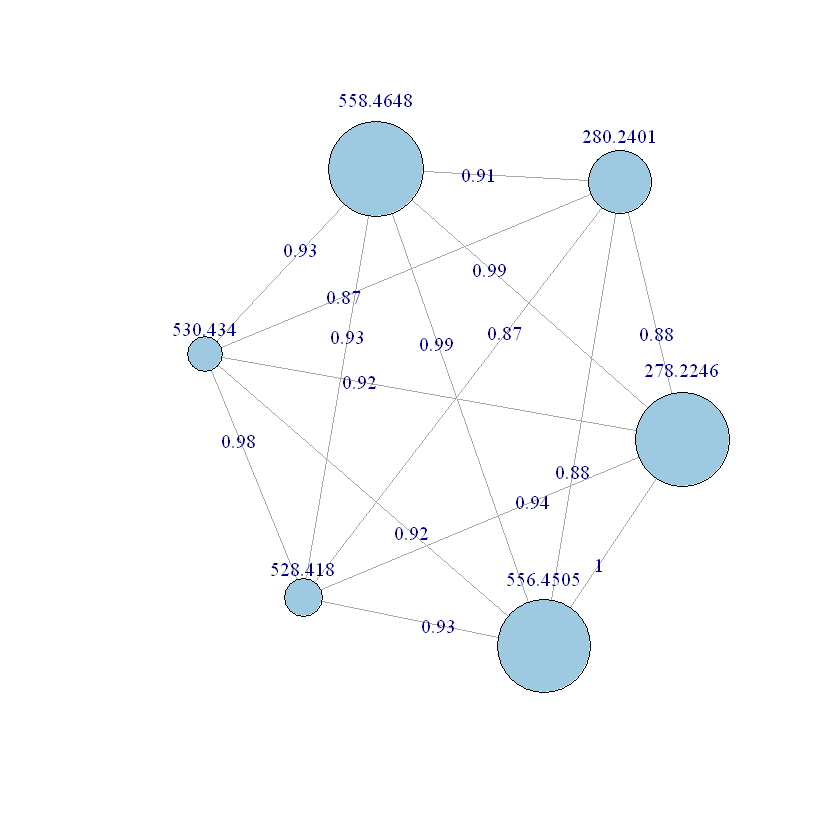

In [9]:
plot_graph(features = P, cluster, name_col = "Name",
             mz_col = "mz", rt_col = "rt")

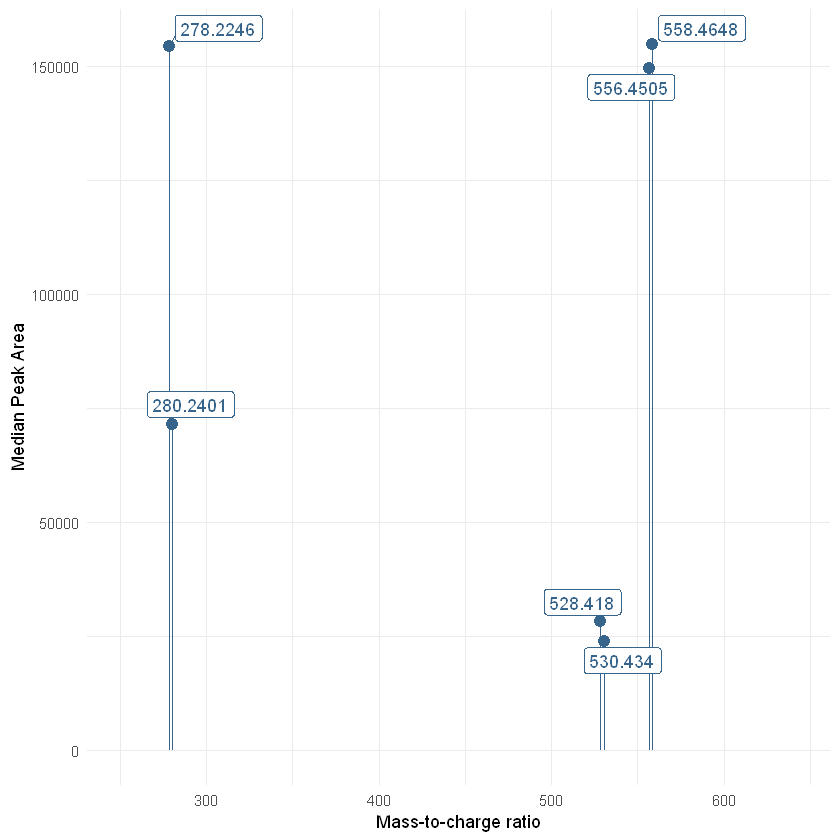

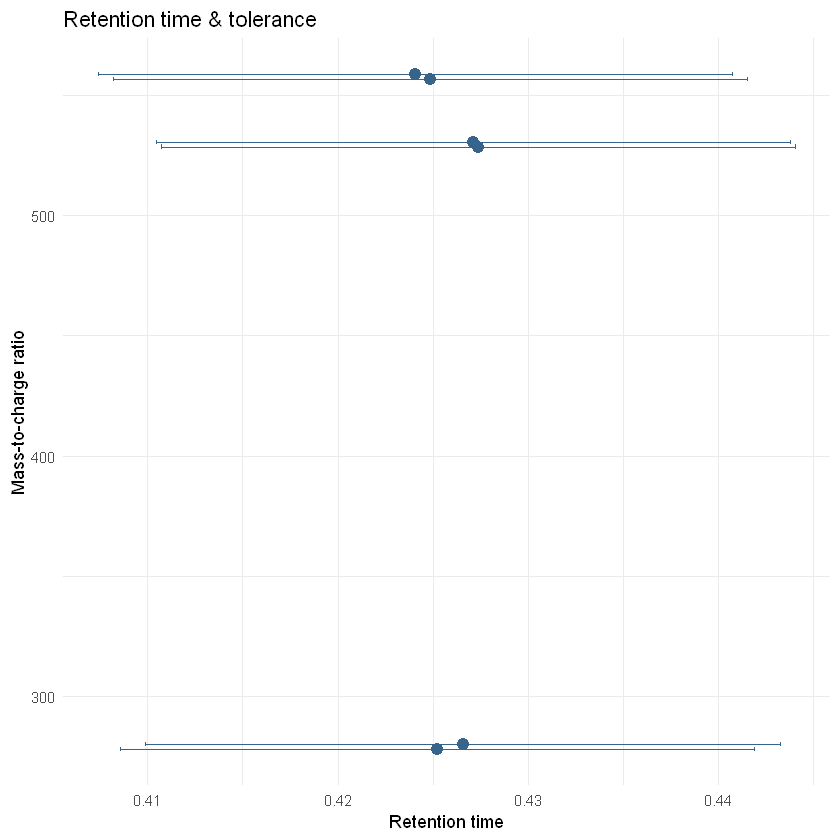

In [10]:
plot_features(P, cluster, name_col = "Name", mz_col = "mz", rt_col = "rt", rt_window = 1/60)

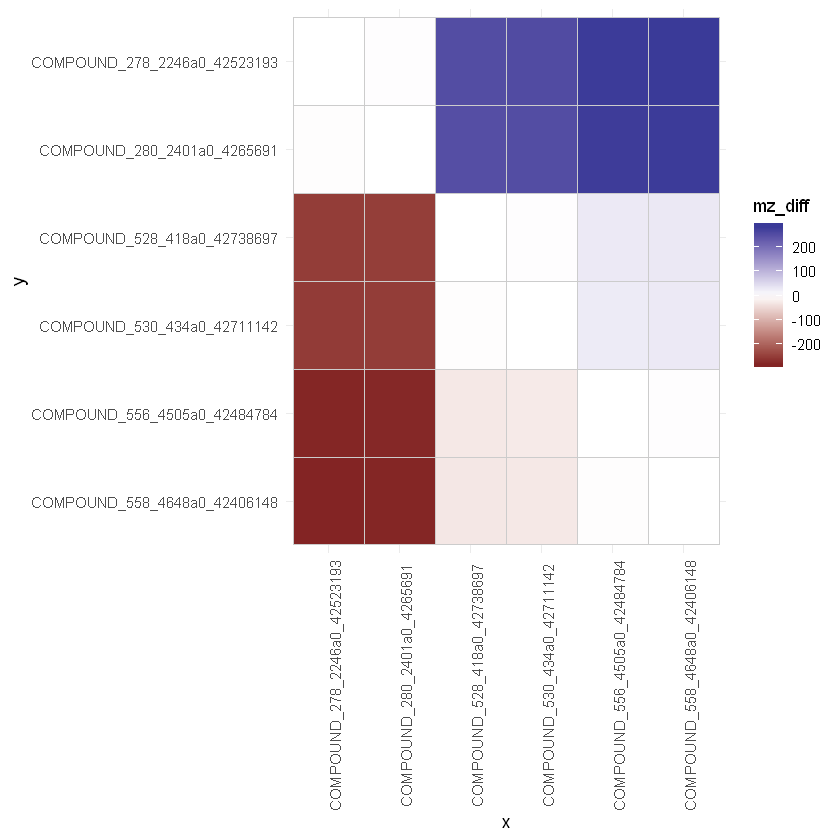

In [12]:
plot_heatmaps(data = X, features = P, cluster = cluster, name_col = "Name", mz_col = "mz", rt_col = "rt")